# Imports

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer, root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from pandas.tseries.offsets import BDay
from sklearn.model_selection import train_test_split

import util.functions as funcs
import yfinance as yf
np.random.seed = 10

EMPRESAS = ['ITUB3.SA', 'PETR4.SA', 'VALE3.SA']

parametros = [
    {'C': .1, 'degree': 3, 'epsilon': .75, 'kernel': 'poly'},
    {'C': 10, 'degree': 3, 'epsilon': .01, 'kernel': 'rbf'},
    {'C': 0.1, 'degree': 3, 'epsilon': .01, 'kernel': 'rbf'},
]

melhoresPeriodosEmpresas = ['5y', '2y', '5y']

# Funções de obtenção, treinamento de modelos e plotagem de resultados

## Obtenção de dados

In [15]:
def get_data_ticker(ticker, period='5y', rolling=1):
    data_orig = yf.download(ticker, period=period)
    data_hist = pd.DataFrame(data_orig['Close'])
    data_hist = data_hist.dropna()
    data_hist['tomorrow'] = data_hist['Close'].rolling(rolling).mean().shift(-1)
    return data_hist

In [16]:
def get_X_y_empresa(EMPRESA, pctTreino, normalizar = False, periodo='5y'):
    df_full = get_data_ticker(EMPRESA, period=periodo)
    df = df_full.dropna()
    
    dates, X, y = funcs.split_df_X_y(df)
        
    data_hist = pd.DataFrame(df['Close'])
    data_hist['mm5'] = data_hist['Close'].rolling(5).mean()
    data_hist['mm15'] = data_hist['Close'].rolling(15).mean()
    data_hist['mm30'] = data_hist['Close'].rolling(30).mean()
    data_hist = data_hist.dropna()
    
    X = data_hist.iloc[:, 1:]
    y = data_hist.iloc[:, 0]

    if(normalizar):
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    
    X_train, y_train = X[:int(len(X) * pctTreino)], y[:int(len(y) * pctTreino)]  
    X_test, y_test = X[int(len(X) * pctTreino):], y[int(len(y) * pctTreino):]   
    
    return X, y, X_train, y_train, X_test, y_test

## Grid Search

In [17]:
def testar_svr_grid_search(EMPRESA, X, y):
    # Define o modelo e os parâmetros a serem testados
    svr = SVR()
    param_grid = {
        'C': [0.01, 0.1, 1, 10],
        'epsilon': [0.01, 0.1, 0.6, 0.75, 1],
        'kernel': ['poly', 'rbf'],
        'degree': [3, 4]
    }
    
    # Configura o TimeSeriesSplit para manter a sequência temporal
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Executa o GridSearchCV com TimeSeriesSplit e r2 como a métrica principal
    grid_search = GridSearchCV(svr, param_grid, cv=tscv, scoring=make_scorer(r2_score))
    grid_search.fit(X, y)
    
    # Melhores parâmetros encontrados
    print("Melhores parâmetros:", grid_search.best_params_)
    print("Melhor Resultado:", grid_search.best_score_)

    return grid_search

## Plotagem em tabelas dos resultados dos parâmetros

In [18]:
def plotar_tabelas(EMPRESA, grid_search):
    # Supondo que `grid_search` já foi executado e `results` já existe
    results = pd.DataFrame(grid_search.cv_results_)
    top_5 = results.nlargest(5, 'mean_test_score')[
        ['param_C', 'param_epsilon', 'param_kernel', 'param_degree', 'mean_test_score', 'std_test_score',
         'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']
    ]
    
    # Renomeia as colunas para deixar claro que a métrica é o R²
    top_5.rename(columns={
        'param_C': 'C',
        'param_epsilon': 'epsilon',
        'param_kernel': 'kernel',
        'param_degree': 'Grau Polinômio',
        'mean_test_score': 'R2 médio',
        'std_test_score': 'Desvio Padrão do R2',
        'split0_test_score': 'split0_r2',
        'split1_test_score': 'split1_r2',
        'split2_test_score': 'split2_r2',
        'split3_test_score': 'split3_r2',
        'split4_test_score': 'split4_r2'
    }, inplace=True)
    
    # Arredonda as colunas numéricas para 2 casas decimais
    #top_5 = top_5.round(3)
    
    # Configurações para o gráfico e tabela
    fig, ax = plt.subplots(figsize=(10, 3))  # Ajuste o tamanho conforme necessário
    ax.axis('tight')
    ax.axis('off')
    
    # Cria a tabela
    table = ax.table(cellText=top_5.values, colLabels=top_5.columns, cellLoc='center', loc='center', )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(len(top_5.columns))))
    
    # Adiciona o título
    ax.set_title(f"Tabela Completa {EMPRESA}", fontsize=12, fontweight='bold', pad=10)
    
    # Exibe a tabela
    plt.show()
    
    # Tabela resumida
    top_5_resumido = top_5.iloc[:, :6]
    
    # Configurações para o gráfico e tabela
    fig, ax = plt.subplots(figsize=(10, 3))  # Ajuste o tamanho conforme necessário
    ax.axis('tight')
    ax.axis('off')
    
    # Cria a tabela
    table = ax.table(cellText=top_5_resumido.values, colLabels=top_5_resumido.columns, cellLoc='center', loc='center', )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(len(top_5_resumido.columns))))
    
    # Adiciona o título
    ax.set_title(f"Tabela Resumida {EMPRESA}", fontsize=12, fontweight='bold', pad=10)
    
    # Exibe a tabela
    plt.show()

# Main

In [ ]:
#EMPRESAS = ['ITUB3.SA', 'VALE3.SA', 'PETR4.SA']
#EMPRESA = 'PETR4.SA'
EMPRESA = 'ITUB3.SA'
#EMPRESA = 'VALE3.SA'
pctTreino = 0.7
grids_searches_empresas = []
X_trains, y_trains, X_tests, y_tests = [], [], [], [] 

#for EMPRESA in EMPRESAS:
X, y, X_train, y_train, X_test, y_test = get_X_y_empresa(EMPRESA, pctTreino)
grid_search = testar_svr_grid_search(EMPRESA, X, y)
grids_searches_empresas.append(grid_search)
plotar_tabelas(EMPRESA, grid_search)

X_trains.append(X_train)
y_trains.append(y_train)
X_tests.append(X_test)
y_tests.append(y_test)

# Previsão com os dados simulados

## Testes Lucas

In [67]:
def prepare_new_record(df, new_record, date_index):
    data_orig = pd.DataFrame({'Close': new_record}, index=[date_index])
    data_orig = data_orig.rename_axis('Date')
    data_orig = pd.concat([df,data_orig])
    data_hist = pd.DataFrame(data_orig['Close'])
    data_hist['mm5'] = data_hist['Close'].rolling(5).mean()
    data_hist['mm15'] = data_hist['Close'].rolling(15).mean()
    data_hist['mm30'] = data_hist['Close'].rolling(30).mean()
    
    return data_hist.tail(1)



In [68]:
def increment_data_df(df, last_predict, offset=0):
   last_date = df.index[-1]
   dia_util = pd.date_range(start=last_date + BDay(1), periods=1, freq=BDay())

   return pd.concat([df, prepare_new_record(df, last_predict, dia_util[0])])

In [75]:
dados = pd.concat([X, y])
dados_forward = dados.copy()

svr = SVR(C=1, degree=3, epsilon=1, kernel='poly')

svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)

last_pred = y_pred[-1]
feed_preds = []
days_to_predict = 14

for d in range(days_to_predict):
    dados_forward = increment_data_df(dados_forward, last_pred, d)
    X_fwd, y_fwd, X_train_fwd, X_test_fwd, y_train_fwd, y_test_fwd = funcs.split_df_X_y(dados_forward)
    last_pred = svr.predict(X_fwd[-n_past:-1])[-1]

    dados_forward.loc[dados_forward.index[-1], 'Close'] = last_pred
    feed_preds.append(last_pred)

ValueError: not enough values to unpack (expected 6, got 3)

## Meus Testes

[*********************100%***********************]  1 of 1 completed


0.9287866321028865
28.543999862670898
29.215999857584634
29.915666580200195
      mm5    mm15       mm30
0  28.544  29.216  29.915667
         mm5       mm15       mm30
0  28.490052  29.093351  29.836675
         mm5       mm15       mm30
0  28.500532  28.981511  29.750089
         mm5       mm15       mm30
0  28.489334  28.895778  29.674889
        mm5       mm15       mm30
0  28.42209  28.789363  29.590348
         mm5       mm15      mm30
0  28.232302  28.708767  29.51305
        mm5       mm15       mm30
0  28.16638  28.603477  29.431072
         mm5       mm15       mm30
0  28.096104  28.488879  29.353106
         mm5       mm15      mm30
0  28.000724  28.341353  29.27801
         mm5       mm15       mm30
0  27.882675  28.237588  29.186794
        mm5      mm15       mm30
0  27.74972  28.17534  29.057337
         mm5       mm15       mm30
0  27.635524  28.097319  28.919326
         mm5       mm15       mm30
0  27.506782  28.034473  28.798236
       mm5       mm15       mm30
0  27

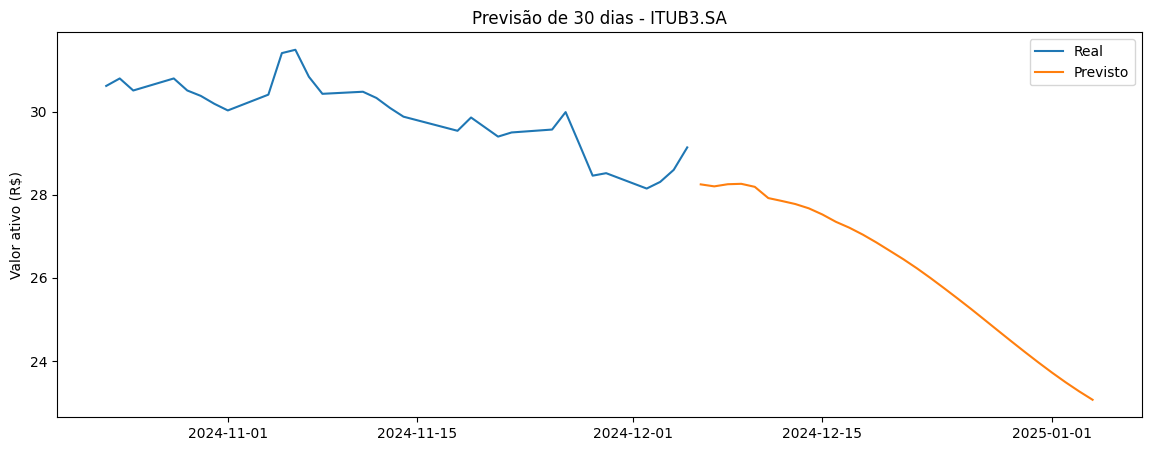

In [ ]:
empresaEscolhida = 0

pctTreino = 0.7

X, y, X_train, y_train, X_test, y_test = get_X_y_empresa(EMPRESAS[empresaEscolhida], pctTreino, periodo=melhoresPeriodosEmpresas[empresaEscolhida])

svr = SVR(**parametros[empresaEscolhida])
#svr = SVR(C=.1, epsilon=.75, kernel='poly', degree=3) #ITUB3
#svr = SVR(C=10, epsilon=.01, kernel='rbf', degree=3) #PETR4
#svr = SVR(C=0.1, epsilon=.01, kernel='rbf', degree=3) #VALE3

svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)
print(r2_score(y_test, y_pred))

# Quantidade de dias a prever
days_to_predict = 30

# Últimos valores conhecidos do histórico, necessários para calcular médias móveis futuras
values = list(y.values)
predictions = []  # Lista para armazenar previsões

# Vamos começar com as últimas médias móveis já calculadas para o dataset
ma_5, ma_15, ma_30 = X['mm5'].values[-1], X['mm15'].values[-1], X['mm30'].values[-1]

print(ma_5)
print(ma_15)
print(ma_30)

for i in range(days_to_predict):
    # Cria a entrada para o modelo usando as médias móveis atuais
    X_input = pd.DataFrame([[ma_5, ma_15, ma_30]], columns=['mm5', 'mm15', 'mm30'])
    print(X_input.head())

    # Realiza a previsão para o próximo dia
    prediction = svr.predict(X_input)[0]
    predictions.append(prediction)

    # Atualiza a lista de valores com a nova previsão
    values.append(prediction)

    # Recalcula as médias móveis usando a lista atualizada
    ma_5 = np.mean(values[-5:])
    ma_15 = np.mean(values[-15:])
    ma_30 = np.mean(values[-30:])

# Convertendo previsões para um DataFrame para facilitar a visualização
future_dates = pd.date_range(y.index[-1] + pd.Timedelta(days=1), periods=days_to_predict)
predicted_df = pd.DataFrame({'Date': future_dates, 'Predicted_Close': predictions}).set_index('Date')

plt.figure(figsize=(14,5))

plt.plot(y_test[-days_to_predict:], label = 'Real')
plt.plot(predicted_df, label = 'Previsto')

plt.title(f"Previsão de {days_to_predict} dias - {EMPRESAS[empresaEscolhida]}")
plt.ylabel("Valor ativo (R$)")

plt.legend()
plt.show()

0.9337936566324107


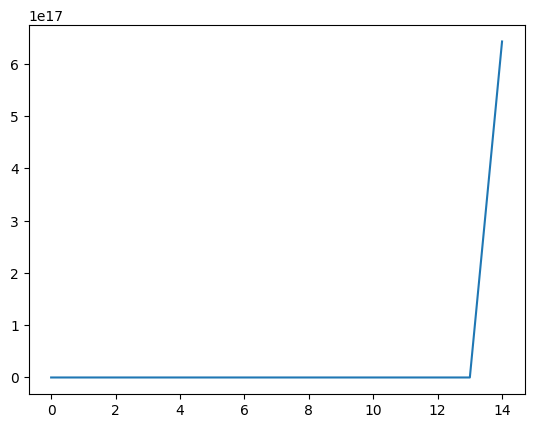

In [91]:
import numpy as np
import pandas as pd

svr = SVR(C=.1, epsilon=.75, kernel='poly', degree=3)
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)
print(r2_score(y_test, y_pred))

# Suponha que os últimos dados de teste estejam em `data_hist`
# Última linha de dados com médias móveis
window_input = X.iloc[-1, :].copy()   # Última linha de médias móveis (mm5, mm15, mm30)

# Inicializa um array para guardar as previsões de 30 dias
predictions_30_days = []

# Emula a previsão de 30 dias com o SVR em uma janela
for i in range(15):
    # Cria DataFrame com os nomes das colunas
    X_input = pd.DataFrame([window_input], columns=['mm5', 'mm15', 'mm30'])

    # Previsão do próximo dia com o SVR
    prediction = svr.predict(X_input)[0]
    predictions_30_days.append(prediction)
    
    # Atualiza a janela com a nova previsão
    # Atualiza as médias móveis
    window_input['mm5'] = np.mean([prediction] + predictions_30_days[-4:])
    window_input['mm15'] = np.mean([prediction] + predictions_30_days[-14:])
    window_input['mm30'] = np.mean([prediction] + predictions_30_days[-29:])

# `predictions_30_days` agora contém a sequência de previsões dos próximos 30 dias

plt.plot(predictions_30_days)

0.9337936566324107


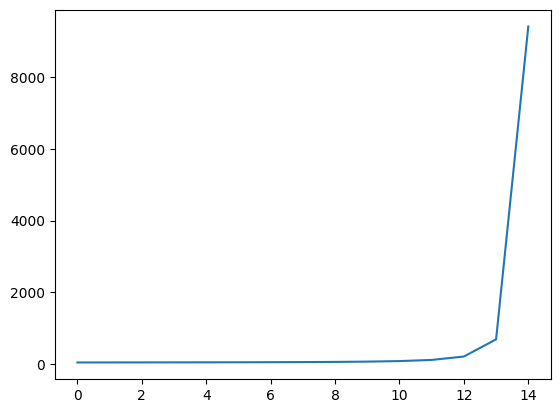

In [92]:
import numpy as np
import pandas as pd


svr = SVR(C=.1, epsilon=.75, kernel='poly', degree=3)
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)
print(r2_score(y_test, y_pred))

# Pega os nomes das colunas de X (dados de treino) para usá-los no predict
feature_names = X.columns

# Última linha de dados como base para a previsão
window_input = X.iloc[-1, :].copy()  # Cópia independente da última linha para evitar alterações diretas
predictions_30_days = []

# Loop para prever os próximos 30 dias
for i in range(15):
    # Prever o próximo valor com o modelo
    X_input = pd.DataFrame([window_input.values], columns=feature_names)
    prediction = svr.predict(X_input)[0]
    predictions_30_days.append(prediction)
    
    # Atualizar as médias móveis com as previsões anteriores
    # Utiliza as últimas 5, 15 e 30 previsões para manter a sequência correta
    mm5_data = predictions_30_days[-4:] if len(predictions_30_days) >= 5 else [prediction] + predictions_30_days[:-1]
    mm15_data = predictions_30_days[-14:] if len(predictions_30_days) >= 15 else [prediction] + predictions_30_days[:-1]
    mm30_data = predictions_30_days[-29:] if len(predictions_30_days) >= 30 else [prediction] + predictions_30_days[:-1]

    window_input['mm5'] = np.mean(mm5_data)
    window_input['mm15'] = np.mean(mm15_data)
    window_input['mm30'] = np.mean(mm30_data)

# `predictions_30_days` contém a sequência de previsões para os próximos 30 dias
plt.plot(predictions_30_days)

In [95]:
import pandas as pd
import numpy as np


svr = SVR(C=.1, epsilon=.75, kernel='poly', degree=3)
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)
print(r2_score(y_test, y_pred))

# Exemplo: Vamos supor que `df['Close']` é a série temporal original
# Parâmetros de janela
window_size = 1  # Número de dias anteriores usados para prever o próximo valor

# Construindo as janelas deslizantes
data = []
for i in range(len(y) - window_size):
    data.append(y.values[i:i + window_size + 1])

data = np.array(data)
X_sliding = data[:, :-1]  # 30 dias anteriores como variáveis de entrada
y_sliding = data[:, -1]   # O próximo dia como variável alvo

#print(X_sliding)
print(y_sliding)




# Dividindo o conjunto de dados para treino e teste
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_sliding, y_sliding, test_size=0.2)

# Treinando o modelo SVR com os parâmetros que você otimizou anteriormente
svr_model = SVR(C=1, epsilon=.75, kernel='poly', degree=2)
svr_model.fit(X_train2, y_train2)









# Começando com a última janela de 30 dias do conjunto de dados original
last_window = X_sliding[-1]

# Lista para armazenar as previsões dos próximos 30 dias
future_predictions = []

# Fazendo a previsão para os próximos 30 dias
for _ in range(30):
    next_pred = svr_model.predict(last_window.reshape(1, -1))[0]
    future_predictions.append(next_pred)
    
    # Atualizando a janela deslizante para incluir a nova previsão
    last_window = np.append(last_window[1:], next_pred)

# Convertendo as previsões para um DataFrame para facilitar a visualização
dates = pd.date_range(y.index[-1] + pd.Timedelta(days=1), periods=30)
future_df = pd.DataFrame({'Date': dates, 'Predicted_Close': future_predictions})






plt.figure(figsize=(12, 6))
plt.plot(y.index, y, label='Histórico')
plt.plot(future_df['Date'], future_df['Predicted_Close'], label='Previsão para 30 dias', color='red')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.title('Previsão dos Próximos 30 Dias')
plt.legend()
plt.show()

0.9337936566324107
[36.02000046 35.59999847 35.59000015 ... 35.15999985 35.38000107
 35.70000076]


ValueError: Input X contains NaN.
SVR does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

# Plotando SVR com os melhores parâmetros do Grid Search e usando o desvio padrão como margem de erro

In [6]:
def treinar_e_plotar_svr_unitario(EMPRESA, X_train, y_train, X_test, y_test, grid_search): 
    svr = SVR(**grid_search)
    
    svr.fit(X_train, y_train)
    
    y_pred = svr.predict(X_test)
    
    # Calculando a diferença e o desvio padrão entre os valores prvistos e os reais para fazer a margem de erro
    diffs = y_pred - y_test #['Close']
    desvio_padrao = np.std(diffs)
    
    # Calculando as faixas superior e inferior
    y_upper = y_pred + desvio_padrao
    y_lower = y_pred - desvio_padrao
    
    # Alinha o índices
    y_pred = pd.Series(y_pred, index=y_test.index)
    y_upper = pd.Series(y_upper, index=y_test.index)
    y_lower = pd.Series(y_lower, index=y_test.index)

    plt.figure(figsize=(14,5))
    plt.plot(y_upper, color='red', linestyle='--', label='Limite Superior')
    plt.plot(y_lower, color='red', linestyle='--', label='Limite Inferior')
    plt.plot(y_pred, label='Predição')
    plt.plot(y_test, color='green', label='Real')

    plt.title(f"SVR - {EMPRESA}")
    plt.ylabel("Valor ativo (R$)")
    plt.legend()
    plt.show()
    
    print(f"R2: {r2_score(y_test, y_pred)}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
    print(f"MSE: {mean_squared_error(y_test, y_pred)}")
    print(f"RMSE: {root_mean_squared_error(y_test, y_pred)}")
    print(f"STD: {desvio_padrao}")

In [ ]:
#for i in range(len(EMPRESAS)):
#    treinar_e_plotar_svr_unitario(EMPRESAS[i], X_trains[i], y_trains[i], X_tests[i], y_tests[i], grids_searches_empresas[i].best_params_)
    

# Testes separados

[*********************100%***********************]  1 of 1 completed


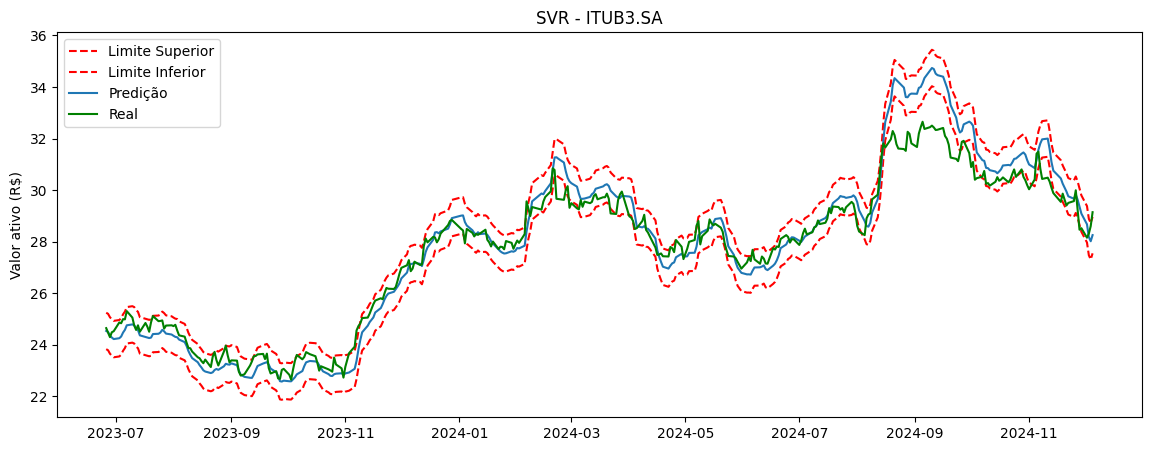

R2: 0.9287866321028865
MAE: 0.5108167144183636
MSE: 0.5256762099975288
RMSE: 0.7250353163795049
STD: 0.7070576847897587


In [ ]:
empresaEscolhida = 0
pctTreino = 0.7

X, y, X_train, y_train, X_test, y_test = get_X_y_empresa(EMPRESAS[empresaEscolhida], pctTreino, periodo=melhoresPeriodosEmpresas[empresaEscolhida])

treinar_e_plotar_svr_unitario(EMPRESAS[empresaEscolhida], X_train, y_train, X_test, y_test, parametros[empresaEscolhida])

[*********************100%***********************]  1 of 1 completed


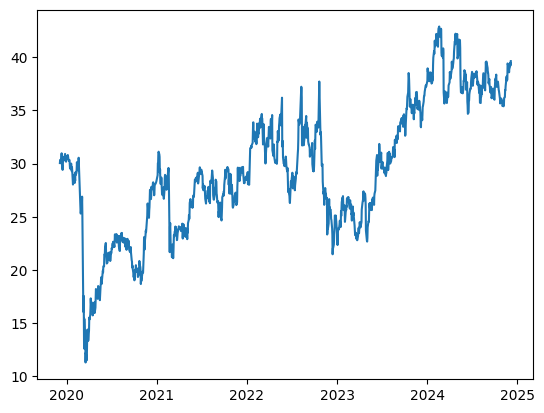

In [36]:
df = get_data_ticker(EMPRESAS[1], period='5y')

plt.plot(df['Close'])